In [2]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import spatial
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = (20,5)

import doremus_data

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record, index - 1
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

Load data.

In [4]:
training_data_folder = '/Users/pasquale/git/recommender/training_data'
emb_folder = '/Users/pasquale/git/music-embeddings'

doremus_data.init(training_data_folder, emb_folder)
vectors, uris, lbs, heads, heads_print = doremus_data.get_embeddings('expression')
pd.DataFrame(heads_print)

,0,1,2,3,4
0,casting,composer,genre,key,composition_date
1,3,3,3,3,1


In [5]:
all_training = doremus_data.all_training('expression')
for t in all_training:
    num_playlists = len(t['playlists'])
    print('%s\t\t%d' % (t['name'], num_playlists))

pp_concerts		223
itema3_concerts		414
web-radio		105
spotify_pl		65


In [6]:
_l = 5

for t in all_training:
    temp_playlists = []
    for pl in t['playlists']:
        for i in np.arange(len(pl['data']) - _l):
            temp_playlists.append(pl['data'][i:i+_l])
    t['groups'] = [{'name':str(index), 'data': pl} for index, pl in enumerate(temp_playlists)]
    print('%s\t\t%d' % (t['name'], len(temp_playlists)))

pp_concerts		1446
itema3_concerts		2678
web-radio		1409
spotify_pl		1511


Data pre-processing

In [79]:
negVector = -2. * np.ones_like(vectors[0], dtype=np.float32)

def get_embs(x, masked=False):
    # uri to embedding
    v = vectors[np.argwhere(uris == x)]
    if v.size == 0:
        print(x)
        result = np.array(negVector)
    else:
        result = np.array(v[0][0])
    if masked:
        result = np.ma.array(result, mask=result < -1.)
    return result

def get_label(x):
    l =  lbs[np.argwhere(uris == x)]
    return l[0][0] if l.size > 0 else 'none'

In [8]:
np.set_printoptions(2)
def compute_playlist_stats(playlist, to_print=False):
    pl = playlist['data']
    embeddings = np.array([get_embs(xi) for xi in pl])
    emb_len = len(embeddings[0])
    
    ma_embeddings = np.ma.array(embeddings, mask=embeddings < -1.)

    # I do not want to mean dimensions with single values
    mul_values = np.where(np.sum(embeddings >= -1., axis=0) > 1, False, True)
    mul_values = np.repeat([mul_values], len(pl), axis=0)
    ma_embeddings = np.ma.array(ma_embeddings, mask=mul_values)

    _mean = ma_embeddings.mean(axis=0)
    _median = np.ma.median(ma_embeddings, axis=0)
    _min = np.ma.min(ma_embeddings, axis=0)
    _max = np.ma.max(ma_embeddings, axis=0)
    _std = np.ma.std(ma_embeddings, axis=0)
    
    if to_print:
        plt.errorbar(np.arange(len(_mean)), _mean, _std, fmt='ok',
                     ecolor='black', elinewidth=1.5, lw=3, capsize=2)
        plt.errorbar(np.arange(len(_mean)), _mean, [_mean - _min, _max - _mean],
                 fmt='.k', ecolor='gray', elinewidth=0.5, lw=1, capsize=1)

        plt.errorbar(np.arange(len(_mean)), _median, fmt='_g',  lw=1)

        plt.xticks(range(len(heads)), heads, rotation=40)
        plt.show()

    return _mean, _median, _std

Sample playlist

Base: spotify_pl
Playlist: 1023


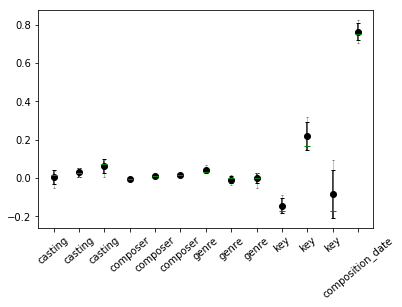

http://overture.doremus.org/expression/ca951b03-f84b-3a7a-aef0-7023af6e8b35
Symhonies
[0.03590903803706169 0.007821599952876568 0.09708871692419052
 -0.006353070493787527 0.008631796576082706 0.015063508413732052
 0.03582938387989998 -0.015889763832092285 0.02758117951452732
 -0.0902123674750328 0.3212423026561737 0.09681284427642822
 0.8038095235824585]
http://overture.doremus.org/expression/41ace8c4-a1b7-3b9d-8339-026e14ed1b54
Symphonies
[-- -- -- -0.003346540266647935 0.012496697716414928 0.012410242110490799
 0.03334466740489006 -0.001616666791960597 0.0029975688084959984
 -0.1695733219385147 0.1698441505432129 -0.1706843227148056
 0.7371428608894348]
http://overture.doremus.org/expression/b53f42ba-9ec1-3e3d-9aa2-1fbff4405093
Requiem
[-0.05006037652492523 0.05418456718325615 0.05414140969514847
 -0.003299245610833168 0.012398893013596535 0.012594932690262794
 0.0664895549416542 0.014949981123209 -0.04941561073064804
 -0.1695733219385147 0.1698441505432129 -0.1706843227148056
 0.705

In [9]:
base = all_training[3]
print('Base: ' + base['name'])
pl = base['groups'][1023]
print('Playlist: ' + pl['name'])

m, md, s = compute_playlist_stats(pl, True)

for d in pl['data']:
    print(d.replace('data', 'overture'))
    print(get_label(d)) 
    print(np.ma.array(get_embs(d), mask=get_embs(d) < -1.))

Standard Deviation among all playlists

In [10]:
population_tot = np.sum([len(pl['data']) for tr in all_training for pl in tr['groups'] ])
std = {}
population = {}
mean = {}
stdw = {} # std within
stdb = {} # std between
                      
for index, tr in enumerate(all_training):
    name = tr['name']
    std[name] = []
    population[name] = []
    mean[name] = []
    for index, pl in enumerate(tr['groups']):
        _mean, _median, _std = compute_playlist_stats(pl, False)
        pop = len(pl['data'])
        population[name].append(pop)
        mean[name].append(_mean)
        ww = (pop - 1) / (population_tot - 1)
        std[name].append((_std**2)*ww)

    stdw[name] = np.ma.sum(std[name], axis=0).filled(0)

In [11]:
weighted_means = [np.ma.mean(mean[name], axis=0)*np.sum(population[name]) for name in mean]

mtot = np.ma.sum(weighted_means, axis=0)
mtot /= population_tot

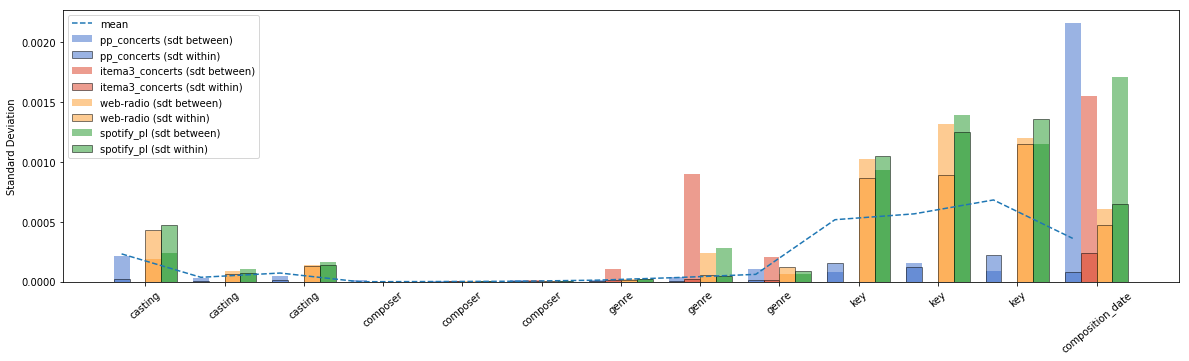

Standard Deviation: mean
[2.33e-04 3.75e-05 7.31e-05 6.52e-07 2.19e-06 4.60e-06 1.36e-05 3.53e-05
 6.20e-05 5.18e-04 5.67e-04 6.83e-04 3.62e-04]
Standard Deviation: minimum
[0.00e+00 0.00e+00 0.00e+00 2.12e-07 1.47e-06 2.89e-06 3.69e-06 8.53e-06
 1.10e-05 0.00e+00 0.00e+00 0.00e+00 8.17e-05]
Standard Deviation between: mean
[1.61e-04 5.63e-05 8.80e-05 5.31e-06 4.64e-06 1.09e-05 3.99e-05 3.65e-04
 1.12e-04 5.11e-04 7.17e-04 6.09e-04 1.51e-03]


In [12]:
fig, ax = plt.subplots(figsize=(20,5))
width = 0.2
pos = np.arange(len(vectors[0]))
colors = ['#3668C9', '#DA3B21', '#FD9827', '#1D9424']


for index, tr in enumerate(all_training):
    name = tr['name']
    
    ww = np.array([pop / (population_tot - 1) for pop in population[name]])
    mg = np.ma.power(np.ma.array(mean[name]).filled(mtot) - mtot, 2)
    stdb[name] = np.ma.sum(mg * ww.reshape(len(ww),1), axis=0)

    plt.bar([p + index * width for p in pos],
        stdb[name],
        width,
        alpha=0.5,
        color=colors[index],
        label=name + ' (sdt between)')
    
    plt.bar([p + index * width for p in pos],
        stdw[name] ,
        width,
        edgecolor='#000000',
        alpha=.5,
        color=colors[index],
        label=name + ' (sdt within)')
    

    
flat_std = [stdw[name] for name in stdw]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)

ax.plot(pos, mstd, '--', label='mean')

plt.xticks(range(len(heads)), heads, rotation=40)
ax.set_ylabel('Standard Deviation')
ax.set_xticks([p + 1.5 * width for p in pos])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')
plt.show()

print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))

flat_std_b = [stdb[name] for name in stdb]
mstd_b = np.ma.mean(flat_std_b, axis=0)
print('Standard Deviation between: mean' )
print(np.array(mstd_b))

#### Explaination

When the standard deviation _within_ (black border) is smaller then the standard deviation _between_ (no border), this means that for that dimension the values are more omogeneuos _inside_ the group than _outside_.
If this difference in omogeneity inside/outside is important, I can state that this dimension drives the playlist generation.

### Graphs property by property

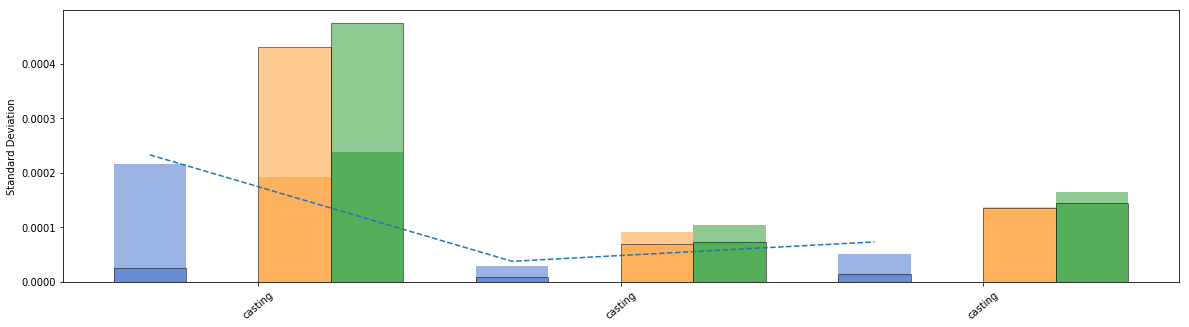

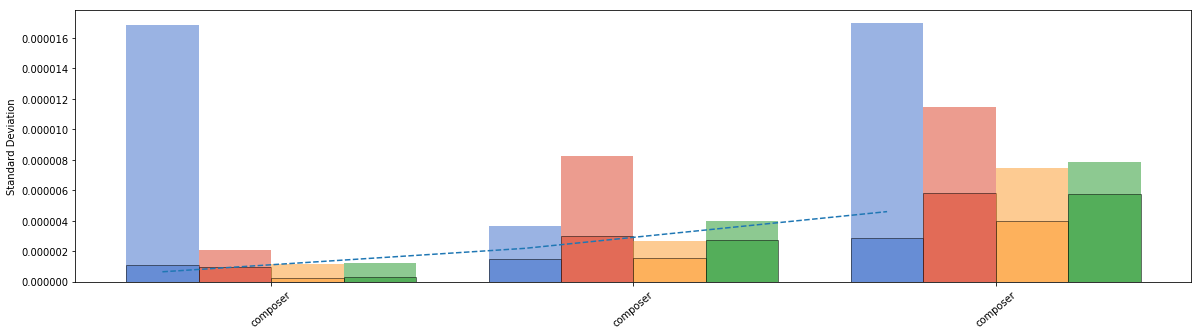

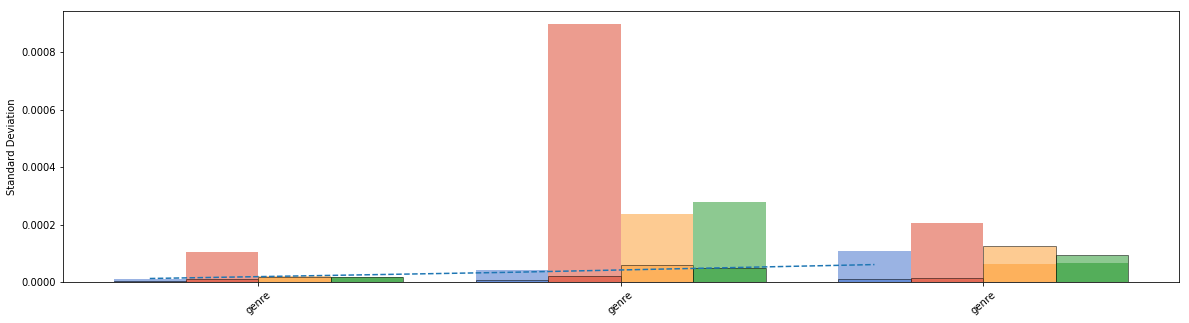

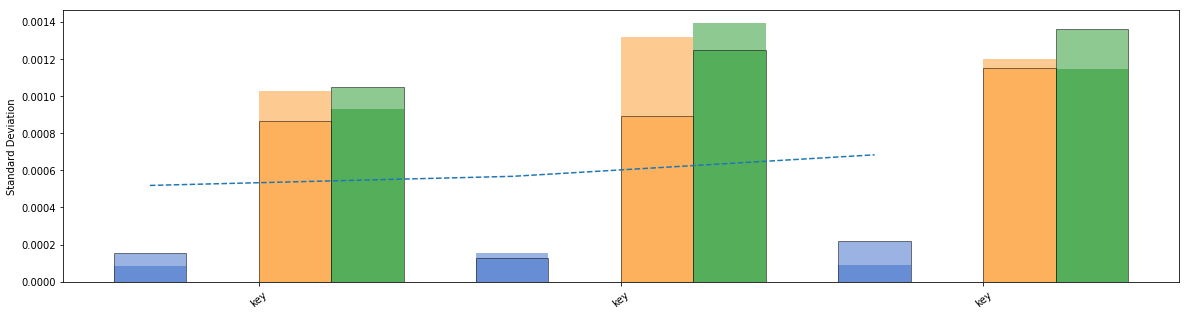

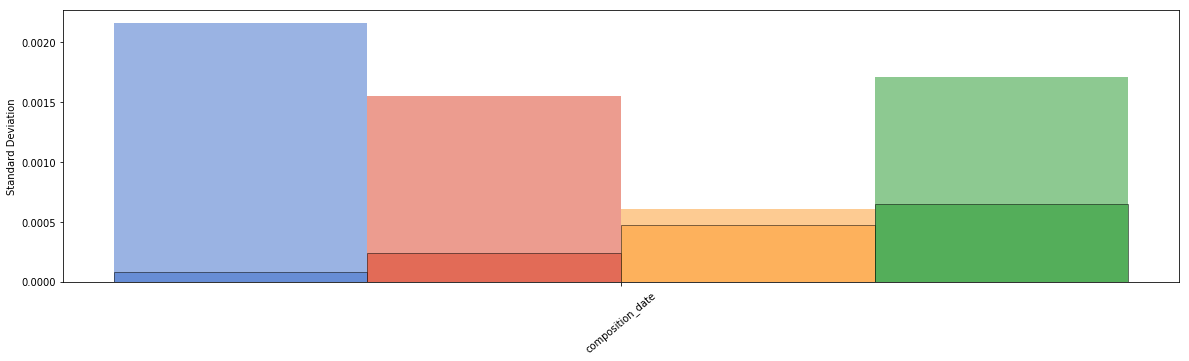

In [13]:
def display_graph(feat):
    pos = np.where(np.array(heads) == feat)[0]
    pos_slide = np.arange(len(pos))
    fig, ax = plt.subplots(figsize=(20,5))

    for index, tr in enumerate(all_training):
        name = tr['name']
        plt.bar([p + index * width for p in pos_slide],
            stdb[name][pos],
            width,
            alpha=0.5,
            color=colors[index],
            label=name + ' (sdt between)')

        plt.bar([p + index * width for p in pos_slide],
            stdw[name][pos] ,
            width,
            alpha=0.5,
            edgecolor='#000000',
            color=colors[index],
            label=name + ' (sdt within)')

    ax.plot(pos_slide, mstd[pos], '--', label='mean')

    plt.xticks(pos_slide, np.array(heads)[pos], rotation=40)
    ax.set_ylabel('Standard Deviation')
    ax.set_xticks([p + 1.5 * width for p in pos_slide])
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, labels, loc='upper left')
    plt.show()
    
    
for _f in heads_print[0]:
    display_graph(_f)

For concerts

In [14]:
flat_std = [s for name in ['pp_concerts','itema3_concerts'] for s in std[name]]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)

print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))
print('Standard Deviation: maximum' )
print(np.array(smax))

Standard Deviation: mean
[5.75e-08 2.07e-08 3.08e-08 6.18e-10 1.32e-09 2.55e-09 5.15e-09 9.59e-09
 8.84e-09 1.76e-06 1.45e-06 2.51e-06 1.69e-07]
Standard Deviation: minimum
[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 3.32e-08 3.55e-09 3.28e-08 0.00e+00]
Standard Deviation: maximum
[4.34e-07 2.16e-07 2.62e-07 7.64e-09 1.45e-08 1.61e-08 1.66e-07 2.10e-07
 2.68e-07 6.89e-06 5.72e-06 8.69e-06 4.12e-05]


For playlists

In [15]:
flat_std = [s for name in ['web-radio','spotify_pl'] for s in std[name]]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)


print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))
print('Standard Deviation: maximum' )
print(np.array(smax))

Standard Deviation: mean
[3.11e-07 4.85e-08 9.58e-08 1.72e-10 1.46e-09 3.33e-09 1.33e-08 3.83e-08
 7.59e-08 1.34e-06 1.50e-06 1.76e-06 3.87e-07]
Standard Deviation: minimum
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Standard Deviation: maximum
[1.58e-06 3.18e-07 5.52e-07 1.71e-09 1.02e-08 1.33e-08 1.61e-07 3.38e-07
 6.62e-07 7.71e-06 8.56e-06 8.69e-06 7.55e-06]


# Computing gaps

In [16]:
def get_std_gap(_chosen):
#     return (stdb[_chosen] - stdw[_chosen]) / ((stdw[_chosen] + stdb[_chosen]) / 2 )
    return  stdb[_chosen] / stdw[_chosen]

def display_distances(_chosen):
    better =(stdw[_chosen]<=stdb[_chosen]).tolist()
    distance = get_std_gap(_chosen)

    pd.set_option('precision', 3)
    return pd.DataFrame([better, distance.tolist(), stdw[_chosen].tolist(), stdb[_chosen].tolist()], 
                        index=['omongeneous', '% rate', 'std within', 'std between'], columns=heads)

In [17]:
display_distances('spotify_pl')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
omongeneous,False,True,True,True,True,True,False,True,False,False,True,False,True
% rate,0.5,1.45,1.14,4.15,1.47,1.37,0.999,5.5,0.728,0.886,1.12,0.843,2.65
std within,0.000475,7.24e-05,0.000144,2.9e-07,2.72e-06,5.75e-06,2.05e-05,5.09e-05,9.42e-05,0.00105,0.00125,0.00136,0.000646
std between,0.000237,0.000105,0.000164,1.21e-06,4e-06,7.87e-06,2.05e-05,0.00028,6.86e-05,0.000931,0.00139,0.00115,0.00171


In [18]:
display_distances('web-radio')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
omongeneous,False,True,True,True,True,True,True,True,False,True,True,True,True
% rate,0.444,1.32,1.01,5.41,1.73,1.88,1.16,3.91,0.495,1.19,1.47,1.04,1.26
std within,0.000432,6.88e-05,0.000135,2.12e-07,1.55e-06,3.96e-06,1.81e-05,6.05e-05,0.000127,0.000868,0.000894,0.00115,0.000478
std between,0.000192,9.09e-05,0.000137,1.15e-06,2.68e-06,7.46e-06,2.1e-05,0.000236,6.27e-05,0.00103,0.00132,0.0012,0.000604


In [19]:
display_distances('pp_concerts')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
omongeneous,True,True,True,True,True,True,True,True,True,False,True,False,True
% rate,8.67,3.29,3.82,14.9,2.49,5.88,3.26,5.07,9.85,0.536,1.23,0.42,26.5
std within,2.49e-05,8.95e-06,1.33e-05,1.13e-06,1.47e-06,2.89e-06,3.69e-06,8.53e-06,1.1e-05,0.000155,0.000127,0.000221,8.17e-05
std between,0.000216,2.94e-05,5.09e-05,1.68e-05,3.64e-06,1.7e-05,1.21e-05,4.33e-05,0.000108,8.31e-05,0.000157,9.26e-05,0.00216


In [20]:
display_distances('itema3_concerts')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
omongeneous,True,True,True,True,True,True,True,True,True,True,True,True,True
% rate,None,None,None,2.14,2.74,1.98,8.68,42.7,12.7,None,None,None,6.37
std within,0,0,0,9.76e-07,3.02e-06,5.79e-06,1.22e-05,2.11e-05,1.63e-05,0,0,0,0.000244
std between,0,0,0,2.09e-06,8.26e-06,1.14e-05,0.000106,0.0009,0.000208,0,0,0,0.00155


2 different tendences between concerts and playlists.

In **concerts** all the dimensions (where they exist) are more omogeneous. This is true in particular for the **casting** (not to be used instead for playlists), and this is reasonable.

The 1st dimension of **composer** is also one to take in account.
In Itema3 this is not visible probably because of bad interlinking of artists.

For the keys, the values are not so relevant and not stable in positiveness.

Always positive (in **bold** the largely ones):
- **composer[0]**
- composer[1,2]
- **genre[2]**
- composition_date
- key[2]
- casting[2]

Positive only in concerts:
- **casting[all]**
- **genre[all]**
- **composition_date**



## Recommendations

In [21]:
def compute_weights(threshold=1.3, fallback = .6, datasets =['spotify_pl']):
    dist = [get_std_gap(_chosen) for _chosen in datasets]
    dist = np.ma.mean(dist, axis=0).filled()

    return np.where(dist > threshold, dist, fallback)

w = compute_weights()
pd.DataFrame([w], columns=heads)

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
0,0.6,1.45,0.6,4.155,1.467,1.368,0.6,5.505,0.6,0.6,0.6,0.6,2.653


In [22]:
all_song = []
for t in all_training:
    if t['name'] in ['web-radio','spotify_pl']:
        for pl in t['playlists']:
             all_song = np.concatenate([all_song, pl['data']])
all_song = np.unique(all_song)
len(all_song)

2563

In [23]:
all_song_vec = np.array([get_embs(xi) for xi in all_song])
all_song_vec = np.ma.array(all_song_vec, mask=all_song_vec < -1.)
all_song_labels = np.array([get_label(xi) for xi in all_song])

In [24]:
def computeSimilarity(seed, target, w):
    b1 = np.where(seed.mask==True)[0]
    b2 = np.where(target.mask==True)[0]
    bad_pos = np.unique(np.concatenate([b1, b2]))

    _seed = np.delete(seed, bad_pos, axis=0)
    _target = np.delete(target, bad_pos, axis=0)
    _w = np.delete(w, bad_pos, axis=0)

    if len(_seed) == 0:
        return 0

    # distance
    d = weightedL2(_seed, _target, _w)

    # how much info I am not finding
    penalty = len([x for x in b2 if x not in b1]) / len(seed)

    # score
    s = (max_distance - d) / max_distance
    return s * (1 - penalty)


def weightedL2(a, b, w=1):
#     return distance.cosine(a,b)
    # https://stackoverflow.com/a/8861999/1218213
    q = a - b
    return np.sqrt((w * q * q).sum())
#     return (w * q * q).sum()


_ones = np.ones(all_song_vec[0].shape)
max_distance = weightedL2(_ones,-_ones, _ones)

In [25]:
_vectors = all_song_vec
_uris =  all_song
_lbs = all_song_labels

def find(seed, n=4, w=None, _print=True):
    global max_distance
    global vectors
    global uris
    global lbs
    
    f_length = len(seed)
    
    _seed = seed
    
    if w is None:
        w = np.ones(len(_seed))
        w = w / w.sum()
    else:
        w = np.array(w)
#         temp = [np.ones(f_length[k]) * w[k] for k in range(len(w))]
#         w = np.array([item for sublist in temp for item in sublist])

    max_distance = weightedL2(np.ones(len(_seed)), np.ones(len(_seed)) * -1, w)

    if _print==True: print('computing scores')
    scores = np.array([[computeSimilarity(_seed, x.astype(float), w) for x in _vectors]])
    full = np.concatenate([_uris.reshape(len(_uris), 1), scores.transpose(), _lbs.reshape(len(_uris), 1)], axis=1)

    # remove the seed from the list
#     full = np.delete(full, pos, 0)

    # sort
    full_sorted = sorted(full, key=lambda _x: float(_x[1]), reverse=True)
    most_similar = full_sorted[:n]
    if _print==True: print('\n'.join('%s %s\n%s' % (f[0], f[1], f[2]) for f in most_similar))

    return [{'uri': _a[0], 'score': float(_a[1])} for _a in most_similar]



In [68]:
def recommend_compare(playlist, w, pos=-1, num_candidates=[100, 200, 500], verbose=True, overture=True):
    pl_data = playlist['data']
    pl_population = len(pl_data)
    if verbose: print('%d items | %s' % (pl_population, playlist['name'].split('/')[-1]))
    
    _replcm = 'overture.' if overture else 'data.'
    
    if pos < 0: 
        pos = random.randrange(pl_population)
   
    chosen = pl_data[pos]
    if verbose: 
        print('seed: %d) %s' % (pos, get_label(chosen)))
        print('\t '+ chosen.replace('data.', _replcm))
    
    first = get_embs(chosen)
#     print(len(np.where(first < -1.)[0]))
#     print(first)
    first = np.ma.array(first, mask=first < -1.)
#     print(first)

    candidates = find(first, n=np.max(num_candidates), _print=False )
    candidates_2 = find(first, n=np.max(num_candidates), _print=False, w = w )
    
    results = np.zeros((len(num_candidates), 3))
    pool = pl_data[min(pos-5,0):max(pos+5, len(pl_data))]
    pool_pop = len(pool)
#     pool = pl_data
#     pool_pop = pl_population
    
    for qi, q in enumerate(num_candidates):
        trues_flat = 0
        for index, c in enumerate(candidates[:q]):
            if c['uri'] == chosen: continue
            if c['uri'] in pool: trues_flat+=1
            if verbose:
                _sig = '  X  ' if c['uri'] in pl_data else '   '
                print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
                print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
        #     display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))


        trues = 0
        for index, c in enumerate(candidates_2[:q]):
            if c['uri'] == chosen: continue
            if c['uri'] in pool: trues+=1
#             if verbose:
#                 _sig = '  X  ' if c['uri'] in pl_data else '   '
#                 print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
#                 print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
#                 # display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))

        if verbose: print('%d | flat %d | weighted %d | diff %d' % (q, trues_flat, trues, trues-trues_flat))
        results[qi] = [trues / pool_pop, trues_flat / pool_pop, (trues-trues_flat) / pool_pop]
    return results

In [83]:
pl = all_training[3]['playlists'][41]
recommend_compare(pl, w, 14)

15 items | 37i9dQZF1DX6Oqe1LC2A2s.Next Classical.expression.txt
seed: 14) Symphonies. No 8
	 http://overture.doremus.org/expression/05874d0b-9f40-3301-a69e-32cd7a9384df
1 	 0.99997	   	Before heaven, before earth
				http://overture.doremus.org/expression/94cd3c61-e253-3b89-a501-d5f63efdade0
2 	 0.99987	   	City Noir
				http://overture.doremus.org/expression/6455f075-105b-3699-a890-905255e90e1a
3 	 0.99987	   	Snapshot symphony
				http://overture.doremus.org/expression/2b4457de-3da8-3056-8293-df4ce378a21d
4 	 0.99908	   	My father knew Charles Ives
				http://overture.doremus.org/expression/aefa1206-eaa4-3e40-9d2e-4237011b02eb
5 	 0.99783	   	Arcanes symphoniques
				http://overture.doremus.org/expression/cdccb4ee-c4e1-344b-91c9-cab568b6f7a8
6 	 0.99709	   	Metropolis symphony
				http://overture.doremus.org/expression/960f8528-a5c5-30a8-ae5b-bff88646bcc0
7 	 0.99525	   	Symphonies. No 2
				http://overture.doremus.org/expression/47f290ec-9743-330c-a5c1-6871b336fc32
8 	 0.99511	  X  

3 	 0.99987	   	Snapshot symphony
				http://overture.doremus.org/expression/2b4457de-3da8-3056-8293-df4ce378a21d
4 	 0.99908	   	My father knew Charles Ives
				http://overture.doremus.org/expression/aefa1206-eaa4-3e40-9d2e-4237011b02eb
5 	 0.99783	   	Arcanes symphoniques
				http://overture.doremus.org/expression/cdccb4ee-c4e1-344b-91c9-cab568b6f7a8
6 	 0.99709	   	Metropolis symphony
				http://overture.doremus.org/expression/960f8528-a5c5-30a8-ae5b-bff88646bcc0
7 	 0.99525	   	Symphonies. No 2
				http://overture.doremus.org/expression/47f290ec-9743-330c-a5c1-6871b336fc32
8 	 0.99511	  X  	Symphonies. No 1
				http://overture.doremus.org/expression/a3ce8f6f-e772-30ba-a449-b684095e533e
9 	 0.99490	   	Symphonies. No 11. ETW 130
				http://overture.doremus.org/expression/c03dcea4-428c-3232-9cc4-4f9c0f5cd9bb
10 	 0.99472	   	Polaris
				http://overture.doremus.org/expression/f720cc67-3527-362b-b57b-012a36393e22
11 	 0.99471	   	Expo
				http://overture.doremus.org/expression/434f498e

105 	 0.99009	   	Symphonie de chambre
				http://overture.doremus.org/expression/c190cf92-bf3b-36c0-b23a-2ae9889dd4b2
106 	 0.99007	   	Miserere hominibus
				http://overture.doremus.org/expression/549a9d87-ca88-3f8e-b94e-6d2e98bc751b
107 	 0.99005	   	Dona nobis pacem
				http://overture.doremus.org/expression/0238d7dd-7cd0-3bac-8b0c-e05214ef6525
108 	 0.99004	   	Symphonies. Si mineur. No 6. Op. 54
				http://overture.doremus.org/expression/930ae69b-0e0d-30e9-9937-d47f8cd582ea
109 	 0.99004	   	Matinées musicales
				http://overture.doremus.org/expression/239940ef-0f09-37a2-85f6-f6f1119b9eff
110 	 0.98998	   	Concertos. Piano, orchestre. No 1. Op. 28
				http://overture.doremus.org/expression/a9896a2d-715c-33e3-ba59-b0b2cd736859
111 	 0.98997	   	The deer's cry
				http://overture.doremus.org/expression/0a6e416f-7f60-3685-b542-d3f24a23d61b
112 	 0.98994	   	Suite provençale
				http://overture.doremus.org/expression/055dde83-a13d-3fdb-98ae-d4216083163d
113 	 0.98992	   	Kanon pokaja

1 	 0.99997	   	Before heaven, before earth
				http://overture.doremus.org/expression/94cd3c61-e253-3b89-a501-d5f63efdade0
2 	 0.99987	   	City Noir
				http://overture.doremus.org/expression/6455f075-105b-3699-a890-905255e90e1a
3 	 0.99987	   	Snapshot symphony
				http://overture.doremus.org/expression/2b4457de-3da8-3056-8293-df4ce378a21d
4 	 0.99908	   	My father knew Charles Ives
				http://overture.doremus.org/expression/aefa1206-eaa4-3e40-9d2e-4237011b02eb
5 	 0.99783	   	Arcanes symphoniques
				http://overture.doremus.org/expression/cdccb4ee-c4e1-344b-91c9-cab568b6f7a8
6 	 0.99709	   	Metropolis symphony
				http://overture.doremus.org/expression/960f8528-a5c5-30a8-ae5b-bff88646bcc0
7 	 0.99525	   	Symphonies. No 2
				http://overture.doremus.org/expression/47f290ec-9743-330c-a5c1-6871b336fc32
8 	 0.99511	  X  	Symphonies. No 1
				http://overture.doremus.org/expression/a3ce8f6f-e772-30ba-a449-b684095e533e
9 	 0.99490	   	Symphonies. No 11. ETW 130
				http://overture.doremus.

100 	 0.99022	  X  	En rêve
				http://overture.doremus.org/expression/fc6ad44b-d7eb-3d75-8c7e-108b75700de2
101 	 0.99020	   	Final Alice. Acrostic song
				http://overture.doremus.org/expression/943c8a84-7120-35fc-b04b-cbfab696ef50
102 	 0.99019	   	Les animaux modèles
				http://overture.doremus.org/expression/e8729d63-0695-314e-8082-5ca585fc8905
103 	 0.99018	   	To thee old cause
				http://overture.doremus.org/expression/364c27aa-2f1d-3362-9f87-ff76876d1da5
104 	 0.99010	   	Luminosity
				http://overture.doremus.org/expression/e37cb1f8-ec0f-3eb9-aaa4-815994e88ec1
105 	 0.99009	   	Symphonie de chambre
				http://overture.doremus.org/expression/c190cf92-bf3b-36c0-b23a-2ae9889dd4b2
106 	 0.99007	   	Miserere hominibus
				http://overture.doremus.org/expression/549a9d87-ca88-3f8e-b94e-6d2e98bc751b
107 	 0.99005	   	Dona nobis pacem
				http://overture.doremus.org/expression/0238d7dd-7cd0-3bac-8b0c-e05214ef6525
108 	 0.99004	   	Symphonies. Si mineur. No 6. Op. 54
				http://overture

197 	 0.98814	   	White man sleeps
				http://overture.doremus.org/expression/e4585722-6b6e-32bc-9df9-be8856188704
198 	 0.98812	   	Vitraux d'église
				http://overture.doremus.org/expression/70383fec-6b9a-373b-9225-d9c5c52502e9
199 	 0.98809	   	The tempest
				http://overture.doremus.org/expression/de9b5ad9-4bf9-393c-a522-a2a584d41eb4
200 	 0.98809	   	The tempest
				http://overture.doremus.org/expression/dfa107eb-1b66-37c8-b02c-0233f41e59cb
201 	 0.98807	   	Oblivión
				http://overture.doremus.org/expression/b99f2f93-26c8-3de8-abed-400a519d3b95
202 	 0.98803	   	Rhapsodie du Värmland
				http://overture.doremus.org/expression/d71cc664-28a1-311e-9e60-89388925e373
203 	 0.98801	   	Dead man walking
				http://overture.doremus.org/expression/5ddfa589-8c2f-399f-b91e-f9150d17ce14
204 	 0.98801	   	The red violin
				http://overture.doremus.org/expression/0fce3214-b336-376a-97b8-beb975fb1fc8
205 	 0.98800	   	Von Zeit zu Zeit
				http://overture.doremus.org/expression/9a161f3c-bbb9-3e3

270 	 0.98679	   	Un Américain à Paris
				http://overture.doremus.org/expression/993e327e-fd10-33b9-8554-9afbda7aabfb
271 	 0.98677	   	Suite for symphonic strings
				http://overture.doremus.org/expression/98943b8b-4630-3c2d-9956-eed1ec18b2a3
272 	 0.98677	   	Fêtes romaines
				http://overture.doremus.org/expression/f968b901-9324-3986-b590-477e6f4ab832
273 	 0.98675	   	Flos campi
				http://overture.doremus.org/expression/818fb940-277a-3a52-ac8c-ad7c60d108e7
274 	 0.98675	   	Industry
				http://overture.doremus.org/expression/d4df5972-8029-307a-a430-12cebda58781
275 	 0.98674	   	Ohé
				http://overture.doremus.org/expression/c1eee8a9-263c-3f58-a740-58f23c91f968
276 	 0.98674	   	Spring fire
				http://overture.doremus.org/expression/f6004055-d3d6-3b0c-8de2-5a48e43faea8
277 	 0.98670	   	4 motets pour le temps de Noël
				http://overture.doremus.org/expression/1be01ef6-ecfd-30c9-9772-6a32348a9556
278 	 0.98669	   	Concertos. Clarinette, orchestre. FS 129
				http://overture.doremu

369 	 0.98530	   	Concertos. Violon, orchestre. FS 61
				http://overture.doremus.org/expression/7ad01603-7640-397e-ac67-bc32b4f6d58a
370 	 0.98529	   	Quatuors. Cordes. Do majeur. No 2. Op. 36
				http://overture.doremus.org/expression/8f9cfe5b-b896-3550-8365-c34a60360ac5
371 	 0.98526	   	2 studi
				http://overture.doremus.org/expression/ead17366-b775-39a7-ab84-31c83cfb32f4
372 	 0.98526	   	5 pièces
				http://overture.doremus.org/expression/9d14ca1a-4d2b-38c4-be2a-fca12e2cfb0e
373 	 0.98524	   	I vow to thee, my country
				http://overture.doremus.org/expression/63058879-a22a-3e2b-8b6d-9c376ad08b7a
374 	 0.98523	   	Turandot
				http://overture.doremus.org/expression/8e662278-74ea-305f-9e17-cfc290d273d5
375 	 0.98522	   	Der Mond
				http://overture.doremus.org/expression/3db25e06-c626-3610-ab39-4c72c1431706
376 	 0.98520	   	Kammermusik
				http://overture.doremus.org/expression/0383bf22-a66c-3fa7-8271-55d443edefc6
377 	 0.98519	   	Die Okeaniden
				http://overture.doremus.org/e

466 	 0.98415	   	Il tramonto
				http://overture.doremus.org/expression/9b0a991d-5851-3ceb-8859-39d8504f2523
467 	 0.98414	   	Mattinata
				http://overture.doremus.org/expression/c0d3f34b-0c0c-3071-a783-13e6972140ab
468 	 0.98412	   	36 Variations
				http://overture.doremus.org/expression/2294786c-79a8-398c-b096-3064cc0c20f8
469 	 0.98412	   	Études. Piano mécanique. No 6
				http://overture.doremus.org/expression/d677b418-503f-3a22-8b76-cca1456dc72e
470 	 0.98412	   	Palestrina
				http://overture.doremus.org/expression/856e025e-eedc-35e8-bcaa-89ac498833f1
471 	 0.98412	   	The red pony
				http://overture.doremus.org/expression/d893b6ea-49bb-31b8-b8ee-1793d8316abc
472 	 0.98412	   	Lullabies
				http://overture.doremus.org/expression/c9d5db02-4501-3766-b79a-ff663f629b68
473 	 0.98409	   	Caténaires
				http://overture.doremus.org/expression/a7ac66df-d654-3d3c-b7d3-5f7f4445d164
474 	 0.98408	   	Les quatre saisons
				http://overture.doremus.org/expression/2dd2d9ec-1e56-3a6e-903f-7

array([[0.27, 0.13, 0.13],
       [0.27, 0.27, 0.  ],
       [0.53, 0.4 , 0.13]])

### Playlists

In [37]:
rc = {}
quantities = [100, 200, 500]
_headers = np.array([['weighted %d' % q, 'flat %d' % q, 'diff %d' % q] for q in quantities]).flatten()

def compute_for_dataset(dataset, w):
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for pl, idxp in log_progress(playlists, name=dataset['name']):
        rcomp = [recommend_compare(pl, w, elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        current[idxp] = np.mean(rcomp, axis=0)
    return current

In [29]:
def evaluate(w, toPrint=False):
    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset, w)
    
    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    if toPrint:    
        return pd.DataFrame(
            _data,
            index = [ds for ds in rc],
            columns = _headers
        )
    else:
        return _data

In [30]:
evaluate(w, True)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=5)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=5)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.077,0.058,0.019,0.115,0.111,0.005,0.219,0.232,-0.013
spotify_pl,0.090,0.086,0.004,0.142,0.130,0.012,0.317,0.294,0.024


I try with different values

In [34]:
def try_with(threshold):
    w = compute_weights(threshold=threshold)

    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [185]:
from IPython.display import display, HTML

for dataset in all_training[2:4]:
    playlists = dataset['playlists']
    for pl in playlists:
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        missing = [len(np.where(get_embs(item) < -1.)[0]) for item in pl['data']]
        _counts = sorted(pd.Series(missing).value_counts().reset_index().values.tolist())
        _pt = ['%d (%d)' % (item[0], item[1]) for item in _counts]
        print('\t\t\t'+'\t'.join(_pt))

FM-401_20161219_00-23
			0 (2)	3 (9)	6 (1)
FM-401_20170102_00-23
			0 (4)	3 (7)	6 (1)
FM-401_20170109_00-02
			0 (3)	3 (4)	4 (1)
FM-401_20170116_00-02
			0 (7)	3 (14)	4 (1)	6 (4)
FM-401_20170116_00-23
			0 (5)	3 (12)	6 (4)
FM-401_20170123_00-23
			0 (13)	3 (8)	6 (3)	7 (1)
FM-401_20170130_00-02
			0 (10)	3 (14)	4 (2)	6 (3)
FM-401_20170130_00-23
			0 (4)	3 (5)	6 (1)
FM-401_20170206_00-23
			0 (8)	1 (1)	3 (15)	4 (1)	6 (1)
FM-401_20170213_00-02
			0 (3)	3 (17)	6 (1)
FM-401_20170213_00-23
			0 (3)	3 (5)	6 (1)
FM-401_20170220_00-02
			0 (3)	3 (9)	4 (1)
FM-401_20170220_00-23
			0 (14)	1 (1)	3 (8)	6 (1)	9 (1)
FM-401_20170227_00-02
			0 (9)	3 (19)
FM-401_20170227_00-23
			0 (6)	1 (1)	3 (4)	6 (4)
FM-401_20170306_00-02
			0 (4)	1 (1)	3 (3)	4 (1)	6 (1)
FM-401_20170313_00-02
			3 (23)	6 (4)
FM-401_20170313_00-23
			0 (5)	3 (3)	4 (3)
FM-401_20170320_00-02
			3 (10)	6 (5)
FM-401_20170320_00-23
			0 (15)	3 (9)	4 (1)	6 (3)
FM-401_20170327_00-02
			0 (13)	1 (1)	3 (17)	6 (3)	9 (1)
FM-401_20170327_00-23
	

			0 (24)	1 (2)	3 (31)	4 (1)	6 (1)
37i9dQZF1DX7cBprxbt1Fn.Gentle Classical: From Dusk till Dawn
			0 (19)	1 (3)	3 (30)	4 (3)	6 (8)
37i9dQZF1DX8GBmCO89g8U.Electroacoustic 50: Spotify Picks
			3 (14)	6 (1)
37i9dQZF1DX8ONeLSIu0Ai.Modernism 50: Spotify Picks
			0 (3)	3 (26)	6 (4)	9 (1)
37i9dQZF1DX8qDhzfjyTN6.Romantic Era 50: Spotify Picks
			0 (20)	1 (1)	3 (16)	6 (2)
37i9dQZF1DX9CrmarDZuOr.Classical World: Sweden
			0 (3)	1 (1)	3 (7)
37i9dQZF1DX9G9wwzwWL2k.Epic Classical
			0 (24)	1 (1)	3 (27)	4 (1)	6 (8)	9 (1)
37i9dQZF1DX9OZisIoJQhG.Morning Classical
			0 (11)	1 (1)	3 (17)	4 (4)	6 (3)
37i9dQZF1DX9uCW6Pqg2WK.Classical World: Germany
			0 (6)	1 (3)	3 (16)	7 (2)
37i9dQZF1DXaQeL9mwtfsG.70 After 70: Creativity & Longevity
			0 (7)	3 (18)	4 (1)	6 (6)
37i9dQZF1DXaSipEWiHbyL.Classical World: USA
			0 (2)	3 (39)	4 (2)	6 (4)
37i9dQZF1DXabrEiRjQMgs.Classical Dance Music: Ballet & Beyond
			0 (7)	3 (20)	6 (4)	9 (1)
37i9dQZF1DXah8e1pvF5oE.Piano 100: Spotify Picks
			0 (10)	3 (44)	4 (4)	6 (8)
37i9dQZF1

In [3]:
try_with(1.4)

NameError: name 'try_with' is not defined

In [187]:
try_with(1.5)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=5)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=5)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.039,0.037,0.003,0.063,0.066,-0.003,0.153,0.150,0.003
spotify_pl,0.073,0.067,0.006,0.118,0.107,0.010,0.227,0.214,0.013


In [187]:
try_with(2.)

KeyboardInterrupt: 

In [ ]:
try_with(1.2)

In [ ]:
try_with(1.1)

In [ ]:
try_with(1.)

In [218]:
for dataset in all_training[3:4]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, w, elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

0K7eJJa4mjtkp8pcBhvtpR.Need to Know: Vivaldi
18
0.011 | 0.025 | 0.022
1NNYUduxzrtLDYoyTjAMmW.Je n'aime pas le Classique
29
0.006 | -0.004 | -0.017
2FfAi71dM3LJ9UwghwxEtF.Sleep Time
14
-0.018 | -0.010 | 0.023
2MGfLgZXgSXDsYN3CzaNps.Werken met Klassiek
16
0.012 | 0.048 | 0.037
37i9dQZF1DWSMyxanxz54I.Jean Sibelius - Composer Weekly #005
28
0.011 | 0.003 | 0.055
37i9dQZF1DWSPYCQqDPtY7.Spotify Orchestra: Double Bass
16
-0.004 | 0.000 | 0.056
37i9dQZF1DWSXyN2w7ILMl.Peaceful Choral Music by Living Composers
16
0.009 | 0.060 | 0.091
37i9dQZF1DWTZaA3VFnR5i.Classical World: UK & Ireland
27
-0.011 | 0.007 | -0.016
37i9dQZF1DWUL3kA2TtHbs.Classical World: Finland
14
-0.005 | 0.000 | -0.024
37i9dQZF1DWUfMnnPBigKP.Symphony of the Winds
20
-0.002 | 0.005 | -0.008
37i9dQZF1DWV0gynK7G6pD.Classical New Releases: Spotify Picks
27
-0.001 | -0.005 | 0.005
37i9dQZF1DWVQTBWd2FvK6.Spotify Orchestra: Viola
23
0.004 | 0.000 | -0.012
37i9dQZF1DWVfS4Cdd3PNf.Opera 100: Spotify Picks
59
-0.048 | -0.071 | -0.081
37i9

In [ ]:
0.00030769230769230765 | 0.007507692307692307 | 0.013246153846153847

In [219]:
for dataset in all_training[2:3]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, w, elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

FM-401_20161219_00-23
12
0.000 | 0.017 | -0.076
FM-401_20170102_00-23
12
-0.049 | 0.000 | 0.061
FM-401_20170109_00-02
8
0.125 | -0.025 | -0.031
FM-401_20170116_00-02
26
0.004 | 0.034 | 0.017
FM-401_20170116_00-23
21
0.014 | -0.002 | -0.036
FM-401_20170123_00-23
25
0.011 | -0.002 | 0.052
FM-401_20170130_00-02
29
-0.002 | 0.010 | -0.013
FM-401_20170130_00-23
10
0.010 | -0.030 | -0.033
FM-401_20170206_00-23
26
-0.001 | -0.013 | -0.006
FM-401_20170213_00-02
21
0.000 | -0.009 | -0.005
FM-401_20170213_00-23
9
-0.012 | 0.000 | 0.080
FM-401_20170220_00-02
13
0.017 | -0.065 | 0.030
FM-401_20170220_00-23
25
-0.002 | -0.006 | -0.018
FM-401_20170227_00-02
28
0.010 | 0.001 | -0.008
FM-401_20170227_00-23
15
0.013 | 0.013 | 0.009
FM-401_20170306_00-02
10
-0.030 | 0.010 | -0.003
FM-401_20170313_00-02
27
0.004 | -0.004 | -0.026
FM-401_20170313_00-23
11
0.000 | -0.017 | -0.025
FM-401_20170320_00-02
15
0.000 | 0.116 | 0.118
FM-401_20170320_00-23
28
-0.003 | 0.008 | -0.003
FM-401_20170327_00-02
35
0.004 |

In [ ]:
0.00006349206349206348 | 0.0015492063492063492 | 0.0027333333333333333

In [223]:
for dataset in all_training[3:4]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, compute_weights(threshold=1.4), elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

0K7eJJa4mjtkp8pcBhvtpR.Need to Know: Vivaldi
18
0.014 | 0.025 | 0.019
1NNYUduxzrtLDYoyTjAMmW.Je n'aime pas le Classique
29
0.006 | -0.004 | -0.017
2FfAi71dM3LJ9UwghwxEtF.Sleep Time
14
-0.018 | -0.010 | 0.018
2MGfLgZXgSXDsYN3CzaNps.Werken met Klassiek
16
0.012 | 0.048 | 0.037
37i9dQZF1DWSMyxanxz54I.Jean Sibelius - Composer Weekly #005
28
0.009 | 0.001 | 0.054
37i9dQZF1DWSPYCQqDPtY7.Spotify Orchestra: Double Bass
16
-0.004 | 0.000 | 0.056
37i9dQZF1DWSXyN2w7ILMl.Peaceful Choral Music by Living Composers
16
0.005 | 0.060 | 0.087
37i9dQZF1DWTZaA3VFnR5i.Classical World: UK & Ireland
27
-0.012 | 0.005 | -0.015
37i9dQZF1DWUL3kA2TtHbs.Classical World: Finland
14
-0.005 | 0.000 | -0.024
37i9dQZF1DWUfMnnPBigKP.Symphony of the Winds
20
-0.002 | 0.007 | -0.008
37i9dQZF1DWV0gynK7G6pD.Classical New Releases: Spotify Picks
27
-0.001 | -0.005 | 0.004
37i9dQZF1DWVQTBWd2FvK6.Spotify Orchestra: Viola
23
0.008 | 0.000 | -0.012
37i9dQZF1DWVfS4Cdd3PNf.Opera 100: Spotify Picks
59
-0.047 | -0.070 | -0.082
37i9

In [224]:
for dataset in all_training[2:3]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, compute_weights(threshold=1.4), elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

FM-401_20161219_00-23
12
0.000 | 0.017 | -0.076
FM-401_20170102_00-23
12
-0.049 | 0.000 | 0.047
FM-401_20170109_00-02
8
0.125 | -0.025 | -0.031
FM-401_20170116_00-02
26
0.004 | 0.034 | 0.017
FM-401_20170116_00-23
21
0.014 | -0.002 | -0.036
FM-401_20170123_00-23
25
0.011 | -0.003 | 0.052
FM-401_20170130_00-02
29
-0.004 | 0.010 | -0.014
FM-401_20170130_00-23
10
0.010 | -0.030 | -0.033
FM-401_20170206_00-23
26
-0.001 | -0.015 | -0.006
FM-401_20170213_00-02
21
0.000 | -0.009 | -0.005
FM-401_20170213_00-23
9
-0.012 | 0.000 | 0.080
FM-401_20170220_00-02
13
0.017 | -0.065 | 0.030
FM-401_20170220_00-23
25
-0.002 | -0.006 | -0.018
FM-401_20170227_00-02
28
0.011 | 0.001 | -0.008
FM-401_20170227_00-23
15
0.013 | 0.013 | 0.004
FM-401_20170306_00-02
10
-0.030 | 0.010 | -0.003
FM-401_20170313_00-02
27
0.004 | -0.004 | -0.026
FM-401_20170313_00-23
11
0.000 | -0.025 | -0.025
FM-401_20170320_00-02
15
0.000 | 0.116 | 0.118
FM-401_20170320_00-23
28
-0.003 | 0.008 | -0.003
FM-401_20170327_00-02
35
0.002 |

KeyboardInterrupt: 

In [225]:
for dataset in all_training[3:4]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, compute_weights(threshold=1.5), elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

0K7eJJa4mjtkp8pcBhvtpR.Need to Know: Vivaldi
18
0.014 | 0.028 | 0.006
1NNYUduxzrtLDYoyTjAMmW.Je n'aime pas le Classique
29
0.004 | -0.004 | -0.015
2FfAi71dM3LJ9UwghwxEtF.Sleep Time
14
-0.018 | -0.005 | 0.028
2MGfLgZXgSXDsYN3CzaNps.Werken met Klassiek
16
0.008 | 0.048 | 0.033
37i9dQZF1DWSMyxanxz54I.Jean Sibelius - Composer Weekly #005
28
0.011 | 0.004 | 0.043
37i9dQZF1DWSPYCQqDPtY7.Spotify Orchestra: Double Bass
16
-0.004 | -0.004 | 0.068
37i9dQZF1DWSXyN2w7ILMl.Peaceful Choral Music by Living Composers
16
0.053 | 0.099 | 0.118
37i9dQZF1DWTZaA3VFnR5i.Classical World: UK & Ireland
27
-0.008 | 0.010 | -0.005
37i9dQZF1DWUL3kA2TtHbs.Classical World: Finland
14
-0.010 | 0.000 | -0.030
37i9dQZF1DWUfMnnPBigKP.Symphony of the Winds
20
-0.007 | 0.002 | -0.003
37i9dQZF1DWV0gynK7G6pD.Classical New Releases: Spotify Picks
27
-0.001 | -0.005 | 0.004
37i9dQZF1DWVQTBWd2FvK6.Spotify Orchestra: Viola
23
0.006 | 0.000 | -0.008
37i9dQZF1DWVfS4Cdd3PNf.Opera 100: Spotify Picks
59
-0.049 | -0.075 | -0.093
37i

In [226]:
for dataset in all_training[2:3]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, compute_weights(threshold=1.5), elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

FM-401_20161219_00-23
12
0.000 | 0.017 | -0.076
FM-401_20170102_00-23
12
-0.049 | 0.000 | 0.075
FM-401_20170109_00-02
8
0.125 | -0.025 | -0.031
FM-401_20170116_00-02
26
0.007 | 0.036 | 0.019
FM-401_20170116_00-23
21
0.005 | -0.009 | -0.034
FM-401_20170123_00-23
25
0.011 | -0.003 | 0.058
FM-401_20170130_00-02
29
-0.005 | 0.011 | -0.013
FM-401_20170130_00-23
10
0.020 | -0.020 | -0.043
FM-401_20170206_00-23
26
0.000 | -0.012 | -0.007
FM-401_20170213_00-02
21
0.000 | 0.012 | -0.011
FM-401_20170213_00-23
9
-0.012 | 0.000 | 0.080
FM-401_20170220_00-02
13
0.052 | -0.040 | 0.053
FM-401_20170220_00-23
25
-0.003 | -0.005 | -0.018
FM-401_20170227_00-02
28
0.007 | 0.001 | -0.015
FM-401_20170227_00-23
15
0.009 | 0.009 | 0.000
FM-401_20170306_00-02
10
0.020 | 0.010 | -0.013
FM-401_20170313_00-02
27
0.003 | -0.005 | -0.021
FM-401_20170313_00-23
11
0.000 | -0.017 | -0.025
FM-401_20170320_00-02
15
0.022 | 0.116 | 0.118
FM-401_20170320_00-23
28
0.006 | 0.010 | -0.003
FM-401_20170327_00-02
35
0.002 | -0.

In [71]:
def display_playlist(name, virtuoso=True):
    for base in all_training:
        for index, pl in enumerate(base['playlists']):
            _p = pl['name'].split('/')[-1].replace('.expression.txt', '').replace('.json', '')
            
            if _p == name:
                print('Playlist %d: %s' % (index, pl['name']))

                m, md, s = compute_playlist_stats(pl, True)

                for d in pl['data']:
                    if virtuoso :
                        print(d)
                    else :
                        print(d.replace('data', 'overture'))
                    print(get_label(d)) 
                    print(np.ma.array(get_embs(d), mask=get_embs(d) < -1.))
                return

Playlist: /Users/pasquale/git/recommender/training_data/spotify/output/playlists/list/expression/37i9dQZF1DXaSipEWiHbyL.Classical World: USA.expression.txt


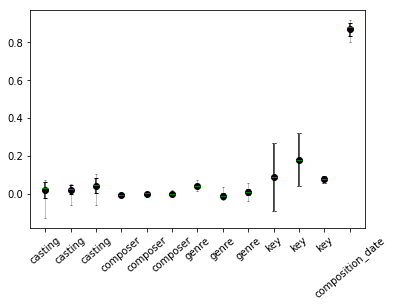

http://overture.doremus.org/expression/deab73a2-7df8-33a8-a864-d051d388af53
Appalachian spring
[0.07214212417602539 0.02443063072860241 0.04946763813495636
 -0.005285804625600576 0.0026602528523653746 -0.004460218828171492
 0.04075663164258003 0.02700350247323513 -0.006292546633630991 -- -- --
 0.8504762053489685]
http://overture.doremus.org/expression/149f59cd-1ce1-37d1-915f-6fd3dcd9a8da
Quatuor. Cordes. Op. 11
[-- -- -- -0.006489186082035303 0.009177939966320992 0.015214388258755207
 0.029902053996920586 -0.02090177871286869 0.0030696517787873745 -- -- --
 0.8438095450401306]
http://overture.doremus.org/expression/db8ecf09-30ae-3bf7-b58f-4154899e6aa5
Rhapsody in blue
[0.017079507932066917 0.027729317545890808 0.051966242492198944
 -0.0042037623934447765 0.0005357147310860455 0.006097358651459217
 0.04075209051370621 -0.0016141104279085994 0.011846732348203659 -- -- --
 0.8323809504508972]
http://overture.doremus.org/expression/9f157ddc-521b-37f6-a399-161bd548ca33
Concord, Mass., 1840

Rothko Chapel
[-0.008673653937876225 0.03249082341790199 0.05368179827928543
 -0.005335659254342318 0.0026575971860438585 -0.004512531217187643 -- --
 -- -- -- -- 0.8771428465843201]
http://overture.doremus.org/expression/132d2ecd-eb5a-3e6e-9734-ee47a9d6e6cc
G song
[0.07298535853624344 0.025212563574314117 0.023253660649061203
 -0.0005389592843130231 0.002983733545988798 0.015036334283649921
 0.029902053996920586 -0.02090177871286869 0.0030696517787873745 -- -- --
 --]
http://overture.doremus.org/expression/d677b418-503f-3a22-8b76-cca1456dc72e
Études. Piano mécanique. No 6
[0.03590903803706169 0.007821599952876568 0.09708871692419052
 -0.005304550286382437 0.002696453360840678 -0.004476765636354685
 0.030921481549739838 -0.0332709364593029 0.021514253690838814 -- -- --
 0.892380952835083]
http://overture.doremus.org/expression/734e465b-d243-39eb-a86a-ce8fa9a73764
Symphonies. No 3
[-0.0017500189132988453 0.047637034207582474 0.0068437689915299416
 -0.0053156581707298756 0.00273772818036

In [232]:
display_playlist('37i9dQZF1DXaSipEWiHbyL.Classical World: USA')

Playlist 63: /Users/pasquale/git/recommender/training_data/web-radio/output/list/expression/FM-401_20171030_00-23.expression.txt


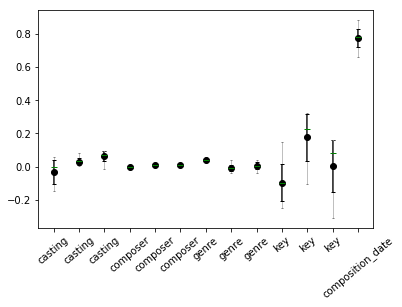

http://overture.doremus.org/expression/1cfaa321-f3d8-3c1e-865e-251be0c85d6d
L'art de la fugue
[-0.010308051481842995 0.023887833580374718 -0.01570785604417324
 -0.005984799470752478 0.007948847487568855 0.015677591785788536
 0.04070869833230972 -0.029023047536611557 0.0015871309442445636 -- -- --
 0.6571428775787354]
http://overture.doremus.org/expression/c640ae6a-166b-39a1-a061-27a5edab4f4e
Sinfonia
[-- -- -- -0.00341302459128201 0.012647601775825024 0.012373256497085094
 0.04500909894704819 -0.0373380184173584 -0.023720722645521164
 -0.21445263922214508 -0.10667538642883301 -0.15358653664588928
 0.7342857122421265]
http://overture.doremus.org/expression/d4905fe5-dca3-39bd-8700-55407cdcaa6d
Sonata
[-0.12156695127487183 0.02923484891653061 0.06187646836042404
 -0.0035184132866561413 0.01287558302283287 0.012367412447929382
 0.04181867465376854 -0.007041075266897678 0.0020058033987879753
 -0.0902123674750328 0.3212423026561737 0.09681284427642822
 0.7733333110809326]
http://overture.dor

In [236]:
display_playlist('FM-401_20171030_00-23')

In [245]:
pl = all_training[3]['playlists'][63]
recommend_compare(pl, w, 15)

73 items | 37i9dQZF1DXddGd6mP5X2a.Orchestra 100: Spotify Picks.expression.txt
seed: 15) Rites of spring
	 http://overture.doremus.org/expression/4c2663ac-25c1-3727-be5e-439bfc0423a1
100 | flat 10 | weighted 4 | diff -6
200 | flat 12 | weighted 11 | diff -1
500 | flat 21 | weighted 18 | diff -3


array([[ 0.05,  0.14, -0.08],
       [ 0.15,  0.16, -0.01],
       [ 0.25,  0.29, -0.04]])

In [32]:
w = compute_weights(datasets=['spotify_pl', 'web-radio'])
pd.DataFrame([w], columns=heads)

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
0,0.6,1.385,0.6,4.783,1.601,1.626,0.6,4.706,0.6,0.6,0.6,0.6,1.958


In [38]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['spotify_pl', 'web-radio'])

    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [39]:
try_with(1.3)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=105)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=65)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.077,0.073,4.543e-03,0.132,0.125,0.007,0.265,0.260,0.005
spotify_pl,0.129,0.130,-8.223e-04,0.188,0.183,0.005,0.326,0.316,0.010


In [40]:
try_with(1.5)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=105)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=65)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.077,0.073,4.749e-03,0.133,0.125,0.008,0.266,0.260,0.006
spotify_pl,0.131,0.130,7.856e-04,0.188,0.183,0.006,0.328,0.316,0.012


In [41]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['web-radio'])

    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [42]:
try_with(1.4)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=105)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=65)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.069,0.073,-0.004,0.122,0.125,-2.995e-03,0.257,0.260,-0.003
spotify_pl,0.123,0.130,-0.007,0.182,0.183,-7.059e-04,0.314,0.316,-0.002


In [43]:
try_with(1.5)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=105)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=65)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.069,0.073,-0.004,0.124,0.125,-5.361e-04,0.258,0.260,-0.002
spotify_pl,0.124,0.130,-0.007,0.182,0.183,-4.962e-04,0.314,0.316,-0.002


In [44]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['pp_concerts', 'itema3_concerts'])

    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [45]:
try_with(3.)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=105)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=65)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.074,0.073,8.127e-04,0.134,0.125,0.009,0.272,0.260,0.012
spotify_pl,0.134,0.130,3.792e-03,0.194,0.183,0.012,0.332,0.316,0.016


In [46]:
try_with(5.)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=105)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=65)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.071,0.073,-1.252e-03,0.131,0.125,0.006,0.271,0.260,0.011
spotify_pl,0.129,0.130,-8.991e-04,0.192,0.183,0.009,0.334,0.316,0.018


In [47]:
try_with(8.)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=105)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=65)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.071,0.073,-1.757e-03,0.130,0.125,0.005,0.272,0.260,0.012
spotify_pl,0.130,0.130,-7.389e-04,0.192,0.183,0.010,0.334,0.316,0.018


In [48]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['pp_concerts', 'itema3_concerts'])

    for dataset, idxd in log_progress(all_training[0:2], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [49]:
try_with(3.)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=223)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=414)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.071,0.073,-1.757e-03,0.130,0.125,0.005,0.272,0.260,1.166e-02
spotify_pl,0.130,0.130,-7.389e-04,0.192,0.183,0.010,0.334,0.316,1.836e-02
pp_concerts,0.014,0.013,1.063e-03,0.019,0.018,0.001,0.026,0.027,-8.643e-04
itema3_concerts,0.000,0.000,0.000e+00,0.000,0.000,0.000,0.000,0.000,0.000e+00


In [50]:
try_with(5.)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=223)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=414)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.071,0.073,-1.757e-03,0.130,0.125,5.459e-03,0.272,0.260,1.166e-02
spotify_pl,0.130,0.130,-7.389e-04,0.192,0.183,9.641e-03,0.334,0.316,1.836e-02
pp_concerts,0.014,0.013,1.032e-03,0.019,0.018,9.941e-04,0.026,0.027,-7.698e-04
itema3_concerts,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00


In [51]:
try_with(8.)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=223)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=414)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.071,0.073,-1.757e-03,0.130,0.125,5.459e-03,0.272,0.260,1.166e-02
spotify_pl,0.130,0.130,-7.389e-04,0.192,0.183,9.641e-03,0.334,0.316,1.836e-02
pp_concerts,0.014,0.013,9.873e-04,0.019,0.018,9.580e-04,0.026,0.027,-8.613e-04
itema3_concerts,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00


In [59]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['itema3_concerts'])

    for dataset, idxd in log_progress(all_training[0:2], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [60]:
try_with(5.)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=223)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=414)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.071,0.073,-1.757e-03,0.130,0.125,0.005,0.272,0.260,0.012
spotify_pl,0.130,0.130,-7.389e-04,0.192,0.183,0.010,0.334,0.316,0.018
pp_concerts,0.015,0.013,2.030e-03,0.019,0.018,0.001,0.030,0.027,0.003
itema3_concerts,0.000,0.000,0.000e+00,0.000,0.000,0.000,0.000,0.000,0.000


In [61]:
try_with(10.)

VBox(children=(HTML(value=''), IntProgress(value=0, max=2)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=223)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=414)))

,weighted 100,flat 100,diff 100,weighted 200,flat 200,diff 200,weighted 500,flat 500,diff 500
web-radio,0.071,0.073,-1.757e-03,0.130,0.125,5.459e-03,0.272,0.260,1.166e-02
spotify_pl,0.130,0.130,-7.389e-04,0.192,0.183,9.641e-03,0.334,0.316,1.836e-02
pp_concerts,0.014,0.013,5.550e-04,0.018,0.018,2.266e-05,0.028,0.027,9.658e-04
itema3_concerts,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00


In [74]:
pl = all_training[0]['playlists'][18]
recommend_compare(pl, w, 2, verbose=True)

28 items | 163468dd-41cc-3818-a874-c867959fe603.json
seed: 2) madrigal
	 http://overture.doremus.org/expression/79456370-2eb3-3abe-91d6-326bc59180a5
0 	 0.99934	   	Ohimè, dov'è il mio ben ?
				http://overture.doremus.org/expression/d2080513-0779-3ab1-a507-7ebbf679e7ab
1 	 0.99377	   	Il ritorno d'Ulisse in patria
				http://overture.doremus.org/expression/c082229f-4143-32b5-aab2-8b665e9a28f1
2 	 0.99360	   	An Wasserflüssen Babylons
				http://overture.doremus.org/expression/332a3035-4d0c-3526-ae0d-7978af922b26
3 	 0.99349	   	Livre 5
				http://overture.doremus.org/expression/b2fd5d68-03c6-370c-9405-f223abf7dace
4 	 0.99320	   	Cantate Domino
				http://overture.doremus.org/expression/888cb9da-3a1c-3a89-8bf9-784033282a0d
5 	 0.99311	   	La Callisto
				http://overture.doremus.org/expression/85b3a0be-d620-35a9-84ab-738fc4ccfbc1
6 	 0.99296	   	Non havea Febo ancora
				http://overture.doremus.org/expression/9d88a5ac-5850-3f9c-8773-8a439fc30688
7 	 0.99287	   	Dalla porta d'oriente
		

0 	 0.99934	   	Ohimè, dov'è il mio ben ?
				http://overture.doremus.org/expression/d2080513-0779-3ab1-a507-7ebbf679e7ab
1 	 0.99377	   	Il ritorno d'Ulisse in patria
				http://overture.doremus.org/expression/c082229f-4143-32b5-aab2-8b665e9a28f1
2 	 0.99360	   	An Wasserflüssen Babylons
				http://overture.doremus.org/expression/332a3035-4d0c-3526-ae0d-7978af922b26
3 	 0.99349	   	Livre 5
				http://overture.doremus.org/expression/b2fd5d68-03c6-370c-9405-f223abf7dace
4 	 0.99320	   	Cantate Domino
				http://overture.doremus.org/expression/888cb9da-3a1c-3a89-8bf9-784033282a0d
5 	 0.99311	   	La Callisto
				http://overture.doremus.org/expression/85b3a0be-d620-35a9-84ab-738fc4ccfbc1
6 	 0.99296	   	Non havea Febo ancora
				http://overture.doremus.org/expression/9d88a5ac-5850-3f9c-8773-8a439fc30688
7 	 0.99287	   	Dalla porta d'oriente
				http://overture.doremus.org/expression/4e1eab7f-7748-30e6-adb7-a6c27d779bd5
8 	 0.99277	   	Ave Maria
				http://overture.doremus.org/expression/4a

101 	 0.98407	   	Geist und Seele wird verwirret
				http://overture.doremus.org/expression/cc48f863-b9e5-3567-aa26-1bddea295ed2
102 	 0.98406	   	Il trionfo del tempo e del disinganno
				http://overture.doremus.org/expression/46901c84-2660-3fe5-ba96-3e6e9d06cbee
103 	 0.98405	   	Motet
				http://overture.doremus.org/expression/f71a989a-06d8-31ea-be15-fdf4933b567d
104 	 0.98401	   	Cantate
				http://overture.doremus.org/expression/2ed791e6-8bbf-3c9d-9ac7-9210e052ce87
105 	 0.98390	   	Il Sedecia re di Gerusalemme
				http://overture.doremus.org/expression/63a49648-dfda-380f-ab03-e366edca1abb
106 	 0.98386	   	Concertos
				http://overture.doremus.org/expression/ce61d8f6-ddb7-30a1-b2ba-7ccace05c7e1
107 	 0.98385	   	Concertos. Viole d'amour, orchestre. Ré majeur. No 1
				http://overture.doremus.org/expression/2fb6d49a-43f8-3829-ac21-36397688afc6
108 	 0.98374	   	Cantate
				http://overture.doremus.org/expression/d7effdd5-4cdf-3ae7-bc15-12d7ccb8548b
109 	 0.98374	   	Sinfonia. Sol m

186 	 0.98054	   	Menuets. Clavecin. Do majeur
				http://overture.doremus.org/expression/a55d08cd-a35e-36ad-96e0-eb8237cc7b9a
187 	 0.98046	   	The cuckoo and the nightingale
				http://overture.doremus.org/expression/1097584d-6d24-3c1d-ae2c-d29699c0c49c
188 	 0.98043	   	Concertos
				http://overture.doremus.org/expression/3fb41a9e-2efb-3ddb-911a-7fa332b08473
189 	 0.98040	   	Sonates. Piano. Do majeur. No 10
				http://overture.doremus.org/expression/06bb4488-d806-32f2-8f81-6ad99531dd15
190 	 0.98040	   	Zaïs
				http://overture.doremus.org/expression/7056c65e-1bb9-32d2-bae4-28b91e8260bb
191 	 0.98040	   	Con amores, la mi madre
				http://overture.doremus.org/expression/463912df-928c-302c-8529-0a8c552dbea4
192 	 0.98034	   	Kommst du nun, Jesu, vom Himmel herunter
				http://overture.doremus.org/expression/530a4012-5aa6-3de2-974c-8c1a1c139500
193 	 0.98034	   	Inventions
				http://overture.doremus.org/expression/391cd062-b95d-3fa3-8993-473c690dd74d
194 	 0.98027	   	Water music
		

63 	 0.98561	   	Sellinger's round
				http://overture.doremus.org/expression/8c20ae5b-6244-3ea7-9725-1df3f0774e5f
64 	 0.98559	   	Simphonia
				http://overture.doremus.org/expression/63c5525c-3202-3ee4-be15-92085f7f7b67
65 	 0.98558	   	Christmas concerto
				http://overture.doremus.org/expression/84aa2198-7362-3de1-8bae-960451e44a2b
66 	 0.98558	   	Concertos grossos
				http://overture.doremus.org/expression/ecd6ca65-3309-3e5a-b79d-8df1f6667da0
67 	 0.98557	   	Hunt cantata
				http://overture.doremus.org/expression/eafc92cd-a788-3edc-b884-5b7d33bd22b9
68 	 0.98554	   	Ode pour l'anniversaire de la Reine Anne
				http://overture.doremus.org/expression/0aeef101-63de-3918-b844-26e2042312a2
69 	 0.98551	   	Nisi Dominus
				http://overture.doremus.org/expression/f1d17291-d912-3d33-a695-187144bf0eec
70 	 0.98538	   	Lost is my quiet for ever
				http://overture.doremus.org/expression/abf7d72b-4368-37b2-acaa-d31d7d5f7a85
71 	 0.98525	   	Concertos grossos. Sol majeur. HWV 314
				http:/

140 	 0.98240	   	Leroy kyrie
				http://overture.doremus.org/expression/006bea20-cb1a-34ab-a07e-f0430f029ada
141 	 0.98235	   	Les quatre saisons
				http://overture.doremus.org/expression/6dd59267-fef0-392d-911f-7abbe676e289
142 	 0.98231	   	Sonates. Violon, clavier. Fa mineur. No 5. BWV 1018
				http://overture.doremus.org/expression/add1e315-d371-3e46-a74c-916d0d2770d5
143 	 0.98218	   	12 concertos
				http://overture.doremus.org/expression/f57d703c-276b-3fbf-bcdb-cfdc3e56ea59
144 	 0.98213	   	Partitas. Vents (5). La majeur. No 4
				http://overture.doremus.org/expression/cbbc5f12-9c9e-30de-a20d-1bf7640e3128
145 	 0.98213	   	Magnificat
				http://overture.doremus.org/expression/8ebabe41-0607-3560-b725-2b5457d95c5c
146 	 0.98206	   	Xerxès
				http://overture.doremus.org/expression/dabc0cb5-238f-37c3-8840-5c4c9da19a3b
147 	 0.98199	   	Concert instrumental sous le titre d'Apothéose composé à la mémoire immortelle de l'incomparable M. de Lully
				http://overture.doremus.org/expr

217 	 0.97898	   	Les paladins
				http://overture.doremus.org/expression/7345d51a-e409-3822-b380-70052d67a007
218 	 0.97897	   	Intégrale des sonates pour clavier
				http://overture.doremus.org/expression/14978fd7-7e94-37fa-b821-9d78c39c1131
219 	 0.97886	   	La servante maîtresse
				http://overture.doremus.org/expression/49d885ba-4921-32f6-b384-976824fd298c
220 	 0.97883	   	Folías
				http://overture.doremus.org/expression/22bcc971-30d4-383f-b555-8770e4bfe6f0
221 	 0.97876	   	Messe de Noël
				http://overture.doremus.org/expression/6201a6c4-80c0-3104-a1ab-469a60e47dd4
222 	 0.97863	   	Rachells weepinge
				http://overture.doremus.org/expression/2e7d6027-df4a-3ad0-9a62-dd55f50a2bec
223 	 0.97850	   	Capriccio stravagante
				http://overture.doremus.org/expression/983283d3-f07a-326d-a135-eff28cfd7efd
224 	 0.97849	   	Concertos. Trompette. Ré majeur
				http://overture.doremus.org/expression/97d21895-3f37-3afa-bf60-a1c08559924e
225 	 0.97849	   	Concertos brandebourgeois
				http:

293 	 0.97453	   	Suites
				http://overture.doremus.org/expression/e1bb1716-122c-3a18-acee-d83171b6eab2
294 	 0.97453	   	Suites
				http://overture.doremus.org/expression/f924be10-b367-34c6-9c3b-eb449f15c101
295 	 0.97451	   	Symphonies
				http://overture.doremus.org/expression/965eb0fd-3962-32ae-a39d-5d3cd2c0bc04
296 	 0.97448	   	Intégrale des quatuors à cordes
				http://overture.doremus.org/expression/12552b99-fc9c-3ce0-89f0-a5938fed7c46
297 	 0.97448	   	Quatuors. Cordes. Sol majeur. KV 73f
				http://overture.doremus.org/expression/31b6ae1e-2e4c-3e5b-8bcf-98384022e45c
298 	 0.97443	   	Sonata
				http://overture.doremus.org/expression/584a3631-d7e5-3100-b411-8056712b7112
299 	 0.97440	   	Toccata pour clavecin en do mineur
				http://overture.doremus.org/expression/ac66d592-ef5f-3440-b9b7-d4a02297b551
300 	 0.97434	   	Toccata pour clavecin en mi mineur
				http://overture.doremus.org/expression/8bd158ae-c127-366d-8bd1-be0ba1963d6c
301 	 0.97432	   	Quintettes. Flûte, quatuor 

368 	 0.97159	   	Trios. Piano, cordes. Mi bémol majeur. No 29. Hob XV 30
				http://overture.doremus.org/expression/e5b6c27c-cdc2-3687-bbc4-650b5c2b091c
369 	 0.97155	   	Concertos
				http://overture.doremus.org/expression/776fee4a-c0fe-3399-ae18-5fcc3aaf4b8b
370 	 0.97154	   	S'asseoir tout deux au bord du flot
				http://overture.doremus.org/expression/54700391-089f-37f6-aa4b-0bf8ae32e78a
371 	 0.97148	   	Sonates. Piano. Fa mineur. Op. 2, no 1
				http://overture.doremus.org/expression/c0960baa-0e6d-31e4-b8b5-21bfe2bc6759
372 	 0.97141	   	Intégrale des quatuors à cordes
				http://overture.doremus.org/expression/d9423934-b6f0-3064-9c00-54d0e5f8195d
373 	 0.97137	   	Sonates. Piano. Do majeur. Op. 2, no 3
				http://overture.doremus.org/expression/f4082bf3-4b1c-3bab-ae99-749c404ba0b9
374 	 0.97132	   	Sérénades. Trio à cordes. Ré majeur. Op. 8
				http://overture.doremus.org/expression/cc3a2ad7-ac6c-3d46-8b45-eab421bf999c
375 	 0.97124	   	Wozu der Vöglein Chöre
				http://overtur

442 	 0.96969	   	Agnus Dei qui tollis
				http://overture.doremus.org/expression/ee81ed5f-f27d-3176-8302-15d0874ee084
443 	 0.96969	   	Ave maris stella
				http://overture.doremus.org/expression/2e6ba2ba-165e-3b4e-8037-4a69ec3ef323
444 	 0.96967	   	In myne zin
				http://overture.doremus.org/expression/4286ebf2-661c-3f08-aecb-a55cda044e95
445 	 0.96961	   	Grande messe des morts
				http://overture.doremus.org/expression/72f417ca-10c9-3a20-a2c2-88ee5b470741
446 	 0.96960	   	Nabucodonosor
				http://overture.doremus.org/expression/72c4cca0-d889-3646-9a59-9112607ecb3f
447 	 0.96960	   	Il finto Stanislao
				http://overture.doremus.org/expression/533862fe-55c3-34c2-a992-ed9f9f569138
448 	 0.96960	   	Sonates. Violoncelle, piano. Do majeur. Op. 102, no 1
				http://overture.doremus.org/expression/a76b90c2-84fc-33a3-b64f-8964effa5d93
449 	 0.96956	   	Le songe d'une nuit d'été
				http://overture.doremus.org/expression/809fc85f-e58e-364b-80c1-18f0975f2907
450 	 0.96947	   	Antigone
			

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

Playlist 18: /Users/pasquale/git/recommender/training_data/concerts/output/list/philharmonie/expression/163468dd-41cc-3818-a874-c867959fe603.json


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


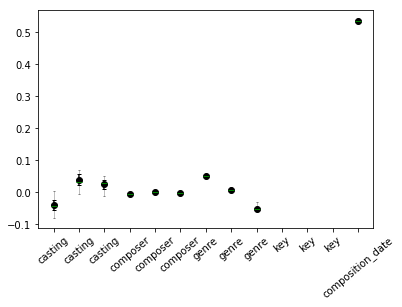

http://overture.doremus.org/expression/e476e90e-2bf6-3591-950f-ba363afe91c3
madrigal
[-0.04822342097759247 0.06663782149553299 0.005517149809747934
 -0.004572320729494095 0.0009616584866307676 -0.0033250199630856514
 0.04990175738930702 0.005862248130142689 -0.053615011274814606 -- -- --
 0.5371428728103638]
http://overture.doremus.org/expression/2dec45a4-545a-352d-b974-d5b5d3fd6a69
madrigal
[-0.00560962175950408 0.05526900291442871 0.022583963349461555
 -0.004572320729494095 0.0009616584866307676 -0.0033250199630856514
 0.04990175738930702 0.005862248130142689 -0.053615011274814606 -- -- --
 0.5371428728103638]
http://overture.doremus.org/expression/79456370-2eb3-3abe-91d6-326bc59180a5
madrigal
[-0.00560962175950408 0.05526900291442871 0.022583963349461555
 -0.004572320729494095 0.0009616584866307676 -0.0033250199630856514
 0.04990175738930702 0.005862248130142689 -0.053615011274814606 -- -- --
 0.5371428728103638]
http://overture.doremus.org/expression/55e6f19a-1130-327e-97ae-f8720f5

In [73]:
display_playlist('163468dd-41cc-3818-a874-c867959fe603', virtuoso=False)

In [81]:
_seed = get_embs('http://data.doremus.org/expression/79456370-2eb3-3abe-91d6-326bc59180a5', masked=True)
_target = get_embs('http://data.doremus.org/expression/2dec45a4-545a-352d-b974-d5b5d3fd6a69', masked=True)
computeSimilarity(_seed, _target, w)

1.0

In [87]:
all_f = find(_seed, _print=False, n=3000)

In [95]:
for a in all_f:
    if a['uri'] == 'http://data.doremus.org/expression/2dec45a4-545a-352d-b974-d5b5d3fd6a69':
        print('found')

In [100]:
for a in all_song:
    if a == 'http://data.doremus.org/expression/2dec45a4-545a-352d-b974-d5b5d3fd6a69':
        print('found')

Playlist 18: /Users/pasquale/git/recommender/training_data/concerts/output/list/itema3/expression/0a2e8bab-a762-3e13-8a1e-236c31976b75.json


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


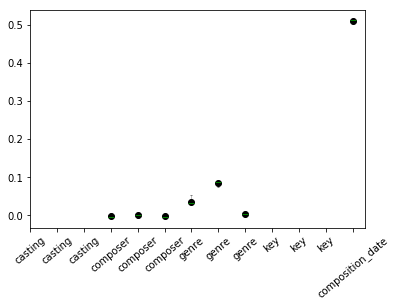

http://data.doremus.org/expression/380034ea-1479-3113-9837-081fe06bb0a5
17 Madrigaux
[-- -- -- -0.004572320729494095 0.0009616584866307676
 -0.0033250199630856514 0.03345714509487152 0.08807671070098877
 0.003515525022521615 -- -- -- 0.5114285945892334]
http://data.doremus.org/expression/c5c6dde9-39c5-381e-8c8d-58948164da33
Lapidabant Stephanum
[-- -- -- -0.004572320729494095 0.0009616584866307676
 -0.0033250199630856514 0.05413346737623215 0.07352088391780853
 -0.0030397160444408655 -- -- -- 0.5066666603088379]
http://data.doremus.org/expression/08a8a84c-7ad3-3024-a82b-e38d51ff327c
Ardi e gela à tua voglia
[-- -- -- -- -- -- 0.03345714509487152 0.08807671070098877
 0.003515525022521615 -- -- -- 0.5114285945892334]
http://data.doremus.org/expression/c5f07fd5-7710-39aa-a2d0-67920dfbe256
21 Canzonette a tre voci (extrait) : Canzonette d'amore che m'uscite del cuore
[-- -- -- -0.004572320729494095 0.0009616584866307676
 -0.0033250199630856514 0.038347527384757996 0.08745533972978592
 0.00

In [72]:
display_playlist('0a2e8bab-a762-3e13-8a1e-236c31976b75', virtuoso=True)